<a href="https://colab.research.google.com/github/carpetmat/Project2/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 2**


---



## **Here are useful links, that I have based the majority of my code off of.**


---



Here is a [helpful page](https://oceanobservatories.org/ooi-m2m-interface/) full of several OOI M2M tutorials.

Timestamp conversion code found [here](https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/extras2/Synchronous_Requests_and_Basic_Plotting.ipynb).

I used [this M2M tutorial](https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/extras2/Using_the_OOI_API_with_Python.ipynb) specifically.

I followed the instructions off [this link](https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html) for cross correlation.

## **Import and set up ALL the important stuff**


---



In [0]:
#Some of these imorts may no longer be relevant, will weed out useless improts later....lol sure I will.

#Lets not clutter our view
%%capture 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import datetime
import os
import re
import pandas as pd
import time
import json
!pip install thredds_crawler
from thredds_crawler.crawl import Crawl
import scipy.stats as ss
from pandas.plotting import register_matplotlib_converters
import statistics as stat
from dateutil.relativedelta import relativedelta

In [0]:
#OOI API authorization information
API_USERNAME = 'OOIAPI-4VTWFS3K3O00B9'
API_TOKEN = 'TEMP-TOKEN-C4MWINON0JLKT1'

In [0]:
#Important first half of a url needed for my M2M requests
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In [0]:
# Time correction, this is really only used for the time-conversion function.
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

## **All my reusable functions**


---



### API information finding function (get_and_print_api)

In [0]:
#A function to make an API request and print the results
#PLEASE NOTE: This is function is only utilized when looking up sensor information. A seperate version is used for making the full M2M requests, see: "Grab_CTD_Data"
def get_and_print_api(url):
  r = requests.get(url, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  for d in data:
    print( d )

### Time conversion function (ntp_seconds_to_datetime)

In [0]:
# This performs a time conversion
def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

### OOI Data request function (Grab_CTD_Data)

In [0]:
# Data request. This will send out the request for the OOI data based off the parameters desired.
def Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN):
  data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  Data_url_add_to_queue = r.json()
  #Data_url_add_to_queue = datacheck['allURLs'][0]
  
  return Data_url_add_to_queue

### Autocorrelate function (autocorr)

In [0]:
# Not entirely sure if I need this function yet, not entirely sure how useful it is either
def autocorr(x, twosided=False, tapered=True):
    """
    Return (lags, ac), where ac is the estimated autocorrelation 
    function for x, at the full set of possible lags.
    
    If twosided is True, all lags will be included;
    otherwise (default), only non-negative lags will be included.

    If tapered is True (default), the low-MSE estimate, linearly
    tapered to zero for large lags, is returned.
    """
    nx = len(x)
    xdm = x - x.mean()
    ac = np.correlate(xdm, xdm, mode='full')
    ac /= ac[nx - 1]
    lags = np.arange(-nx + 1, nx)
    if not tapered:  # undo the built-in taper
        taper = 1 - np.abs(lags) / float(nx)
        ac /= taper
    if twosided:
        return lags, ac
    else:
        return lags[nx-1:], ac[nx-1:]

### OOI data download and selection function (Check_and_Pull)

In [0]:
 #This function pulls the data from the OOI website, it will check to see if the link is ready, then save the data we want as a dataframe.
 def Check_and_Pull(datacheck,Profiler_Name):
  print('Checking for', Profiler_Name,'data')
  #This is the part that checls to ensure the link is ready to go.
  check_complete = datacheck['allURLs'][1] + '/status.txt'
  for i in range(1000): 
      r = requests.get(check_complete)
      if r.status_code == requests.codes.ok:
          print('request was completed, data available')
          break
      else:
          time.sleep(.5)

  url = datacheck['allURLs'][0]
  # files = os.listdir(url)
  print('Downloading Data...')
  #This part then finds and downloads the requested csv file.
  c = Crawl(url, select=['.*\.csv'], debug=False)
  urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
  # print(urls)
  #This downloads each csv, and stores it
  data_list = []
  for i, csv_file in enumerate(urls):
    data_batch = pd.read_csv(urls[i])
    data_list.append(data_batch)
  #This takes all those batches of csv data and puts them into a single dataframe
  data = pd.concat(data_list)

  #This part then sorts the all the data by date, as they may or may not be downloaded in the correct order. (Spoiler alert: they were not)
  data = data.sort_values(by='time',ascending=True).reset_index(drop=True)


  #Now that we theoretically just got data, lets create a data frame we can fill with only the bestest data.
  Data_Return = pd.DataFrame((),
                              columns=['Time','Time_Stamp','Rain_Rate', 'Wind_Speed'])

  #Add the time stamp array
  Data_Return.Time_Stamp = data.time

  #No need to check headers for this, fortunately
  TimeConversion = data.time
  #Convert timestamp to datetime
  TimeConversion = TimeConversion.apply(ntp_seconds_to_datetime)
  #This cuts off the "date" part of the datetime, but looks like we don't want that for project 2. Saving it just in case.
  # TimeConversion = pd.Series([val.time() for val in TimeConversion])

  #Here was add the time data to the data frame
  Data_Return.Time = TimeConversion 
  #Now add the rain rate data
  Data_Return.Rain_Rate = data.met_rainrte
  #Finally the wind speed
  Data_Return.Wind_Speed = data['metbk_a_dcl_instrument-met_relwind_speed'] #Has a nasty '-' in the name, instead of '_', which is why I reference it differently

  #I end up with some unwanted data points in 2020. This section of code finds data points not in 2019 and ELIMINATES THEM.
  DataIndexDrop = []
  for i, DataPoint in enumerate(Data_Return.Time):
      if Data_Return.Time[i].year != 2019:
        DataIndexDrop.append(i)
  Data_Return.drop(Data_Return.index[DataIndexDrop], inplace=True,)
  print('Download Complete')

  return Data_Return

### Missing data filling function (Nan_Val_Masker)

In [0]:
#This function will find and none-existing data (nan), and replace it with a datapoint interpolated from the existing data
def Nan_Val_Masker(X_axis, Y_axis):
  #shamlessly ripped from tutorial, just like the rest of my code D:<
  #I don't how this works yet. Maybe one day. But not today.
  ymask = np.ma.masked_invalid(Y_axis)
  xtab = np.ma.array(X_axis, mask=ymask.mask).compressed()
  ytab = ymask.compressed()

  Y_De_Naned = ymask.filled()   # no longer masked
  Y_De_Naned[ymask.mask] = np.interp(X_axis[ymask.mask], xtab, ytab)
  return Y_De_Naned

### Data Interpolation function (Interpolate_Mah_Datah)



In [0]:
#As our two sets of data have different time intervals, which may also change from day to day. We must interpolate the data over a singular time axis.
def Interpolate_Mah_Datah(Time_X1, Time_X2, Data_Y1, Data_Y2, Resolution):

  #Resolution = The number of data points we want

  #The time axis we will be baseing our Y interpolations off of.
  #Time_X1 = X array for first batch of data (aka timestamp)
  #Time_X2 = X array for second batch of data

  #The data we will be interpolating into new data points, based off of universal time axis
  #Data_Y1 = Y array for first batch of data (aka wind speed or rain rate)
  #Data_Y2 = Y array for second batch of data (aka wind speed or rain rate)

  #Here I chose my time axis end points. I would LIKE to use a nice and rounded time end points.
  #But reversing my time conversion in order to find the timestamp for time 00:00:00:000 is too haaaaaarrrrd ;_;
  #So instead, I chose the earilest and latest timestamp as my end points
  if min(Time_X1) <= min(Time_X2):
    t_min = min(Time_X1)
  else:
    t_min = min(Time_X2)

  if max(Time_X1) >= max(Time_X2):
    t_max = max(Time_X1)
  else:
    t_max = max(Time_X2)

  # Make a uniform grid, with the same number of points:
  Unified_Time = np.linspace(t_min, t_max, Resolution)

  #Interpolate our first set of data over new time axis
  Y1_Int = np.interp(Unified_Time, Time_X1, Data_Y1)
  #Interpolate our second set of data over new time axis
  Y2_Int = np.interp(Unified_Time, Time_X2, Data_Y2)

  # print("standard deviations: ", Data_Y1.std(), Y1_Int.std())
  # print("standard deviations: ", Data_Y2.std(), Y1_Int.std())

  return Y1_Int, Y2_Int, Unified_Time

### Cross-Correlation function: (Correlate_THIS)

In [0]:
def Correlate_THIS(Time_X1, Time_X2, Data_Y1, Data_Y2, Correlation_Info):

  Resolution = 10000
  Y1_Int, Y2_Int, Unified_Time = Interpolate_Mah_Datah(Time_X1, Time_X2, Data_Y1, Data_Y2, Resolution)
  
  x = Unified_Time

  y1 = Nan_Val_Masker(Unified_Time,Y1_Int)
  y2 = Nan_Val_Masker(Unified_Time,Y2_Int)

  ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
  ccor = ccov / (Resolution * y1.std() * y2.std())
  lags = np.linspace(-Resolution + 1, Resolution, len(ccor))

  maxlag = lags[np.argmax(ccor)]
  lag = relativedelta(seconds = (x[int(maxlag)]-x[0]))
  print('Max correlation is',round(max(ccor),3),'at a lag of',int(lag.minutes),'minutes and',int(lag.seconds),'seconds')

  fig, axs = plt.subplots(nrows=2, figsize=[20,10], gridspec_kw={'hspace': .2, 'wspace': 0.1})
  fig.suptitle(f"{Correlation_Info[0]} Correlation for {Correlation_Info[2]}", y=0.95, fontsize=30)

  ax = axs[0]
  ax.scatter(x, y1, c='r',s=2, label='Oregon Shelf Surface Mooring')
  ax.scatter(x, y2, c='b',s=2, label='Oregon Offshore Surface Mooring')
  ax.legend(loc='upper right', fontsize='small', ncol=2)
  ax.set_ylabel(f"{Correlation_Info[0]} ({Correlation_Info[1]})")
  ax.set_xlabel('Timestamp')

  ax = axs[1]
  ax.plot(lags, ccor)
  ax.set_ylim(-1.1, 1.1)
  ax.set_ylabel('Correlation')
  ax.set_xlabel('lag of Oregon Shelf Surface Mooring relative to Oregon Offshore Surface Mooring')

### Plot Cross-Correlation function (Plot_Correlation) (UNFINISHED)

In [0]:
# #This function exclusivley plots the average data. Cause I didn't want to clutter my other function.
# def Plot_Correlation(Data_Table1,Data_Table2):
#   #First lets pull our average data:
#   Wind1, Rain1 = Correlate_THIS(Data_Table1.Time_Stamp, Data_Table1.Time_Stamp, Data_Table1.Wind_Speed, Data_Table1.Wind_Speed)
#   Wind2, Rain2 = Monthly_Avg(Data_Table2)
#   Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#   fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[20,10], gridspec_kw={'hspace': 0, 'wspace': 0.1})
#   fig.suptitle(f"Monthly Average Wind and Rain Data for {Data_Table1.Time[0].year}", y=0.95, fontsize=30)

#   #Left
#   ax1.plot(Months,Wind1, c='r',marker='o',mfc='r', label='Oregon Shelf Surface Mooring')
#   ax1.plot(Months,Wind2, c='b',marker='o',mfc='b', label='Oregon Offshore Surface Mooring')
#   ax1.set_title('Wind Speed vs Time')
#   ax1.set(xlabel='Time (Date)', ylabel='Wind Speed (m/s)')
#   ax1.legend(loc='upper left')
#   ax1.tick_params(axis='both',gridOn=True)

#   #Right
#   ax2.plot(Months,Rain1, c='r',marker='o',mfc='r', label='Oregon Shelf Surface Mooring')
#   ax2.plot(Months,Rain2, c='b',marker='o',mfc='b', label='Oregon Offshore Surface Mooring')
#   ax2.set_title('Rain Rate vs Time')
#   ax2.set(xlabel='Time (Date)', ylabel='Rain Rate (mm/h)')
#   ax2.legend(loc='upper left')
#   ax2.tick_params(axis='both',gridOn=True)

### Plot Wind Speed and Rain Rate function (Plot_Wind_and_Rain)

In [0]:
def Plot_Wind_and_Rain(Data_Table1,Data_Table2):

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey='col', figsize=[20,15], gridspec_kw={'hspace': 0, 'wspace': 0.1})
  # locator = mdates.AutoDateLocator('%b')
  # xformatter = mdates.ConciseDateFormatter(locator)
  months = mdates.MonthLocator() 
  xformatter = mdates.DateFormatter('%b')
  fig.suptitle(f"Wind and Rain Data for {Data_Table1.Time[0].year}", y=0.93, fontsize=30)

  #Top Left
  X1 = Data_Table1.Time
  Y1 = Data_Table1.Wind_Speed
  ax1.scatter(X1,Y1, c='r',s=2, label='Oregon Shelf Surface Mooring')
  ax1.set_title('Wind Speed vs Time')
  ax1.set(xlabel='Time (Date)', ylabel='Wind Speed (m/s)')
  ax1.legend(loc='upper left')
  ax1.xaxis.set_major_formatter(xformatter)
  ax1.xaxis.set_major_locator(months)
  ax1.tick_params(axis='both',gridOn=True)

  #Bottom Left
  X2 = Data_Table2.Time
  Y2 = Data_Table2.Wind_Speed
  ax3.scatter(X2,Y2, c='b',s=2, label='Oregon Offshore Surface Mooring')
  ax3.set(xlabel='Time (Date)', ylabel='Wind Speed (m/s)')
  ax3.legend(loc='upper left')
  ax3.xaxis.set_major_formatter(xformatter)
  ax3.xaxis.set_major_locator(months)
  ax3.tick_params(axis='both',gridOn=True)

  #Top Right
  X3 = Data_Table1.Time
  Y3 = Data_Table1.Rain_Rate
  ax2.scatter(X3,Y3, c='r',s=2, label='Oregon Shelf Surface Mooring')
  ax2.set_title('Rain Rate vs Time')
  ax2.set(xlabel='Time (Date)', ylabel='Rain Rate (mm/h)')
  ax2.legend(loc='upper left')
  ax2.xaxis.set_major_formatter(xformatter)
  ax2.xaxis.set_major_locator(months)
  ax2.tick_params(axis='both',gridOn=True)

  #Bottom Right
  X4 = Data_Table2.Time
  Y4 = Data_Table2.Rain_Rate
  ax4.scatter(X4,Y4, c='b',s=2, label='Oregon Offshore Surface Mooring')
  ax4.set(xlabel='Time (Date)', ylabel='Rain Rate (mm/h)')
  ax4.legend(loc='upper left')
  ax4.xaxis.set_major_formatter(xformatter)
  ax4.xaxis.set_major_locator(months)
  ax4.tick_params(axis='both',gridOn=True)

  #This sets max y value to whichever is greatest between the 2 data sets
  if max(Y1) >= max(Y2):
    ax3.set_ylim(0, max(Y1)+0.1*max(Y1))
  else:
    ax3.set_ylim(0, max(Y2)+0.1*max(Y2))

  if max(Y3) >= max(Y4):
    ax4.set_ylim(0, max(Y3)+0.1*max(Y3))
  else:
    ax4.set_ylim(0, max(Y3)+0.1*max(Y3))

### Find monthly average Wind Speeds and Rain Rates function (Monthly_Avg)

In [0]:
#This function will find the average wind and rain values for each month and return them

#I need to rewrite this so it only goes through the list once, not 12 times...
def Monthly_Avg(Data_Table):
  Monthly_Avg_Wind = []
  Monthly_Avg_Rain = []

  #Filter out nans first, otherwise the avg will be nan
  Data_Table.Wind_Speed = Nan_Val_Masker(Data_Table.Time_Stamp, Data_Table.Wind_Speed)
  Data_Table.Rain_Rate = Nan_Val_Masker(Data_Table.Time_Stamp, Data_Table.Rain_Rate)

  for m in range(1, 13):
    Wind_Sum_er = []
    Rain_Sum_er = []
    for i, Datapoint in enumerate(Data_Table.Time):
      if Data_Table.Time[i].month == m:
        Wind_Sum_er.append(Data_Table.Wind_Speed[i])
        Rain_Sum_er.append(Data_Table.Rain_Rate[i])
      if i == (len(Data_Table)-1):
        Monthly_Avg_Wind.append(stat.mean(Wind_Sum_er))
        Monthly_Avg_Rain.append(stat.mean(Rain_Sum_er))

  return Monthly_Avg_Wind, Monthly_Avg_Rain

### Plot monthly average data function (Plot_Monthly_Avg)

In [0]:
#This function exclusivley plots the average data. Cause I didn't want to clutter my other function.
def Plot_Monthly_Avg(Data_Table1,Data_Table2):
  #First lets pull our average data:
  Wind1, Rain1 = Monthly_Avg(Data_Table1)
  Wind2, Rain2 = Monthly_Avg(Data_Table2)
  Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

  fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[20,10], gridspec_kw={'hspace': 0, 'wspace': 0.1})
  fig.suptitle(f"Monthly Average Wind and Rain Data for {Data_Table1.Time[0].year}", y=0.95, fontsize=30)

  #Left
  ax1.plot(Months,Wind1, c='r',marker='o',mfc='r', label='Oregon Shelf Surface Mooring')
  ax1.plot(Months,Wind2, c='b',marker='o',mfc='b', label='Oregon Offshore Surface Mooring')
  ax1.set_title('Wind Speed vs Time')
  ax1.set(xlabel='Time (Date)', ylabel='Wind Speed (m/s)')
  ax1.legend(loc='upper left')
  ax1.tick_params(axis='both',gridOn=True)

  #Right
  ax2.plot(Months,Rain1, c='r',marker='o',mfc='r', label='Oregon Shelf Surface Mooring')
  ax2.plot(Months,Rain2, c='b',marker='o',mfc='b', label='Oregon Offshore Surface Mooring')
  ax2.set_title('Rain Rate vs Time')
  ax2.set(xlabel='Time (Date)', ylabel='Rain Rate (mm/h)')
  ax2.legend(loc='upper left')
  ax2.tick_params(axis='both',gridOn=True)

## **Code to look up the specific information needed to make a M2M request**


---



In [0]:
# r = requests.get(SENSOR_BASE_URL, auth=(API_USERNAME, API_TOKEN))
# print( r.status_code )
# print( r.headers )
# print( r.encoding )
# print( r.text )
# print( r.json() )

In [0]:
# sites = r.json()
# for site in sites:
#   print( site )

In [0]:
# #CE02SHSM-SBD11-06-METBKA000
# get_and_print_api(SENSOR_BASE_URL+'/CE02SHSM')

In [0]:
# #CE02SHSM-SBD11-06-METBKA000
# #List of Nodes for a Site
# get_and_print_api(SENSOR_BASE_URL+'/CE02SHSM/SBD11')

In [0]:
# #CE02SHSM-SBD11-06-METBKA000
# #List of Methods for a Sensor
# get_and_print_api(SENSOR_BASE_URL+'/CE02SHSM/SBD11/06-METBKA000')

In [0]:
# #CE02SHSM-SBD11-06-METBKA000
# #List of Data Streams for a Method
# get_and_print_api(SENSOR_BASE_URL+'/CE02SHSM/SBD11/06-METBKA000/telemetered')

In [0]:
# # Retrieve information for a Preload Stream given its name. 
# url = 'https://ooinet.oceanobservatories.org/api/m2m/12575/stream/byname/metbk_hourly'
# r = requests.get(url, auth=(API_USERNAME, API_TOKEN))
# data = r.json()

# # Convert to Data Frame
# parameters = pd.DataFrame(data['parameters'])
# parameters[['id','name','data_product_type','display_name','unit']]

In [0]:
# # Retrieve information for a Preload Parameter given its identifier.
# url = 'https://ooinet.oceanobservatories.org/api/m2m/12575/parameter/7'
# r = requests.get(url, auth=(API_USERNAME, API_TOKEN))
# data = r.json()

# print( json.dumps(data, indent=4) )

## **My Data Requests**


---



### 1: Oregon Shelf Surface Mooring

In [0]:
# CE02SHSM-SBD11-06-METBKA000
# telemetered
# metbk_hourly
# 2019-01-01 00:00:00.000
# 2020-01-01 00:00:00.000

#Instrument Information
site = 'CE02SHSM'
node = 'SBD11'
instrument = '06-METBKA000'
method = 'telemetered'
stream = 'metbk_hourly'

params = {
    'beginDT':'2019-01-01T00:00:00.000Z',
    'endDT':'2020-01-01T00:00:00.000Z',
    'format':'application/csv',
    'parameters':'3092,3076,3074',
}

Data_url_add_to_queue1 = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### 2: Oregon Offshore Surface Mooring

In [0]:
# CE04OSSM-SBD11-06-METBKA000
# telemetered
# metbk_hourly
# 2019-01-01 00:00:00.000
# 2020-01-01 00:00:00.000

#Instrument Information
site = 'CE04OSSM'
node = 'SBD11'
instrument = '06-METBKA000'
method = 'telemetered'
stream = 'metbk_hourly'

params = {
    'beginDT':'2019-01-01T00:00:00.000Z',
    'endDT':'2020-01-01T00:00:00.000Z',
    'format':'application/csv',
    'parameters':'3092,3076,3074',
}

Data_url_add_to_queue2 = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## **Compile Data**


---



In [485]:
Profiler_Name = 'Oregon Shelf Surface Mooring'
Data1_OSSM = Check_and_Pull(Data_url_add_to_queue1,Profiler_Name)

Profiler_Name = 'Oregon Offshore Surface Mooring'
Data2_OOSM = Check_and_Pull(Data_url_add_to_queue2,Profiler_Name)

Checking for Oregon Shelf Surface Mooring data
request was completed, data available
Download Complete
Checking for Oregon Offshore Surface Mooring data
request was completed, data available
Download Complete


In [0]:
# Data1_OSSM

In [0]:
# Data2_OOSM

## **Examine Data**


---



### Wind and Rain Plotting

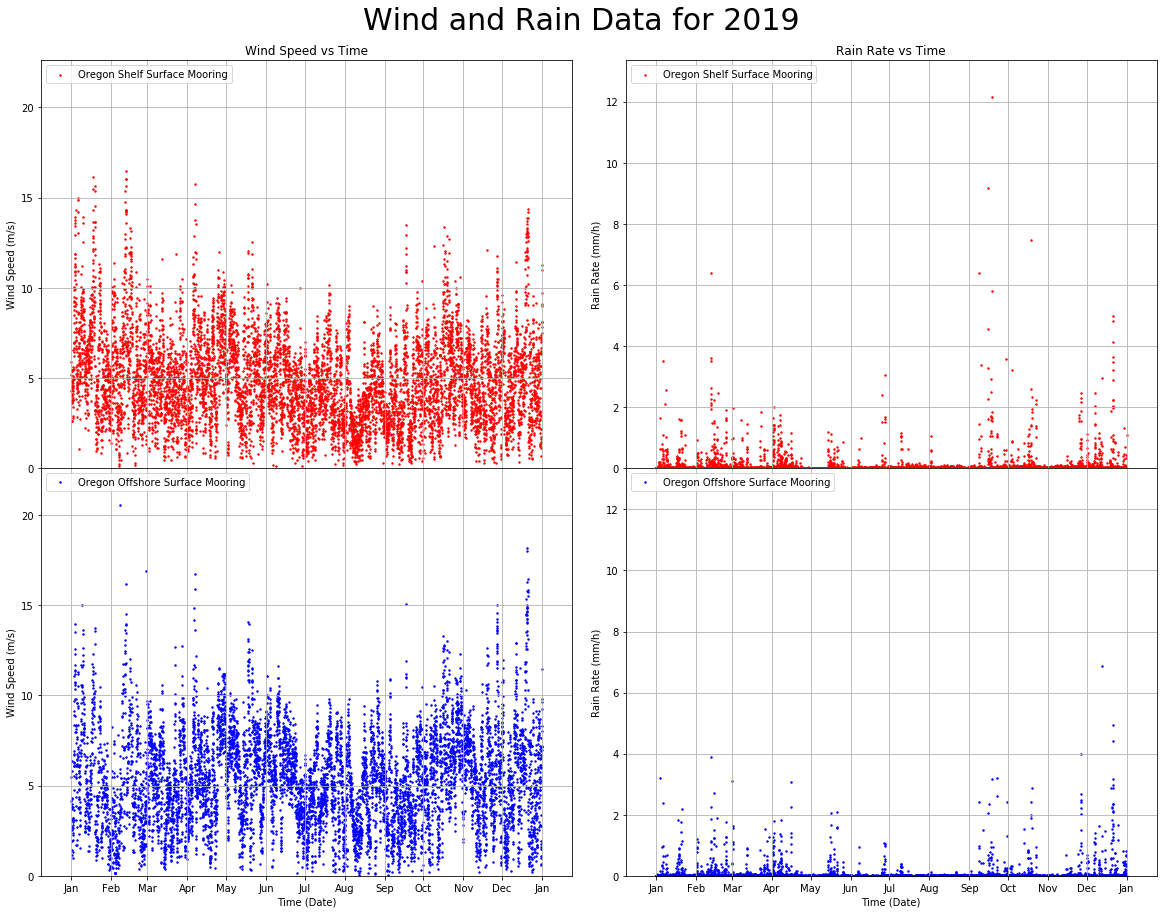

In [488]:
Plot_Wind_and_Rain(Data1_OSSM,Data2_OOSM)

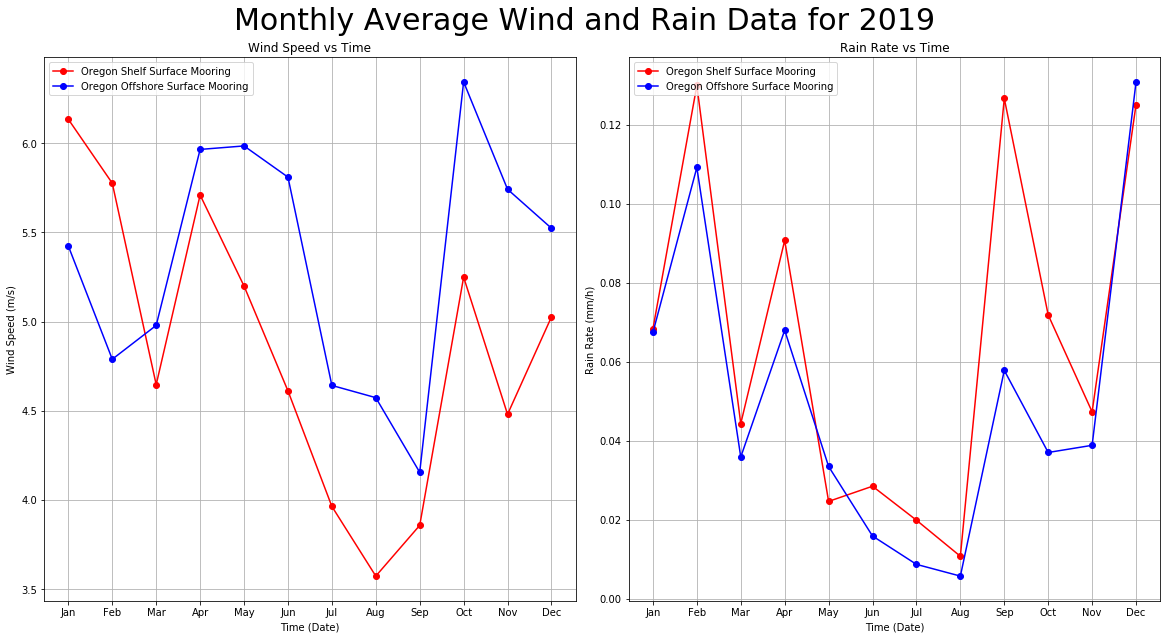

In [489]:
Plot_Monthly_Avg(Data1_OSSM,Data2_OOSM)

### Cross-Correlation

Max correlation is 0.71 at a lag of 0 minutes and 0 seconds


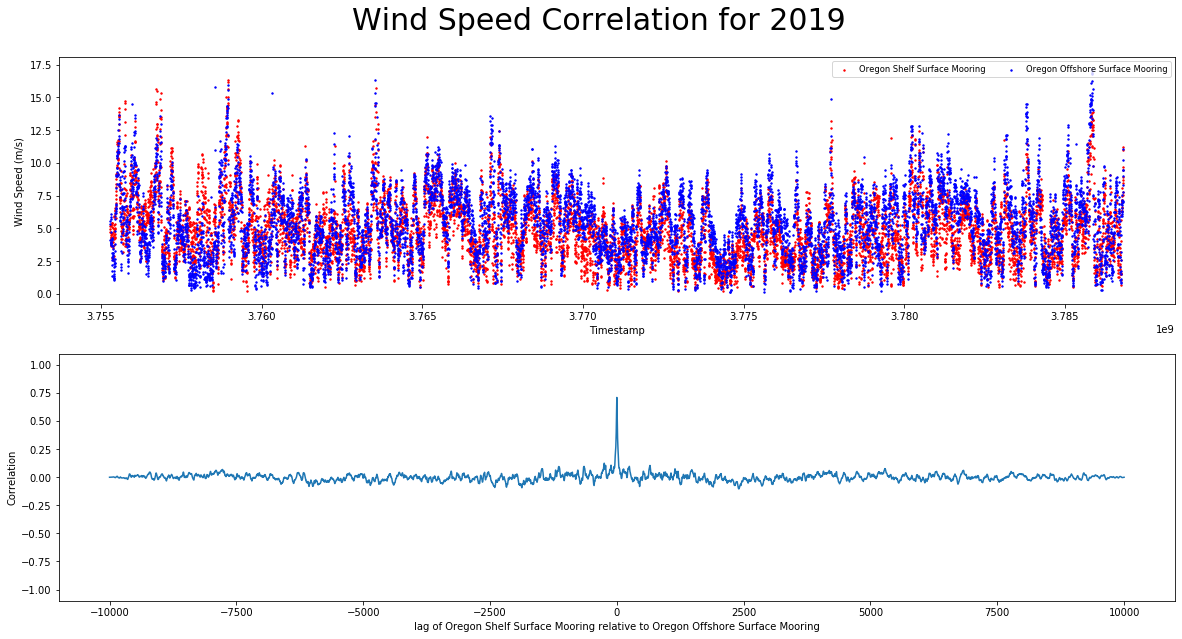

In [490]:
Correlation_Info = ['Wind Speed','m/s','2019']
Correlate_THIS(Data1_OSSM.Time_Stamp, Data2_OOSM.Time_Stamp, Data1_OSSM.Wind_Speed, Data2_OOSM.Wind_Speed, Correlation_Info)

Max correlation is 0.528 at a lag of 52 minutes and 33 seconds


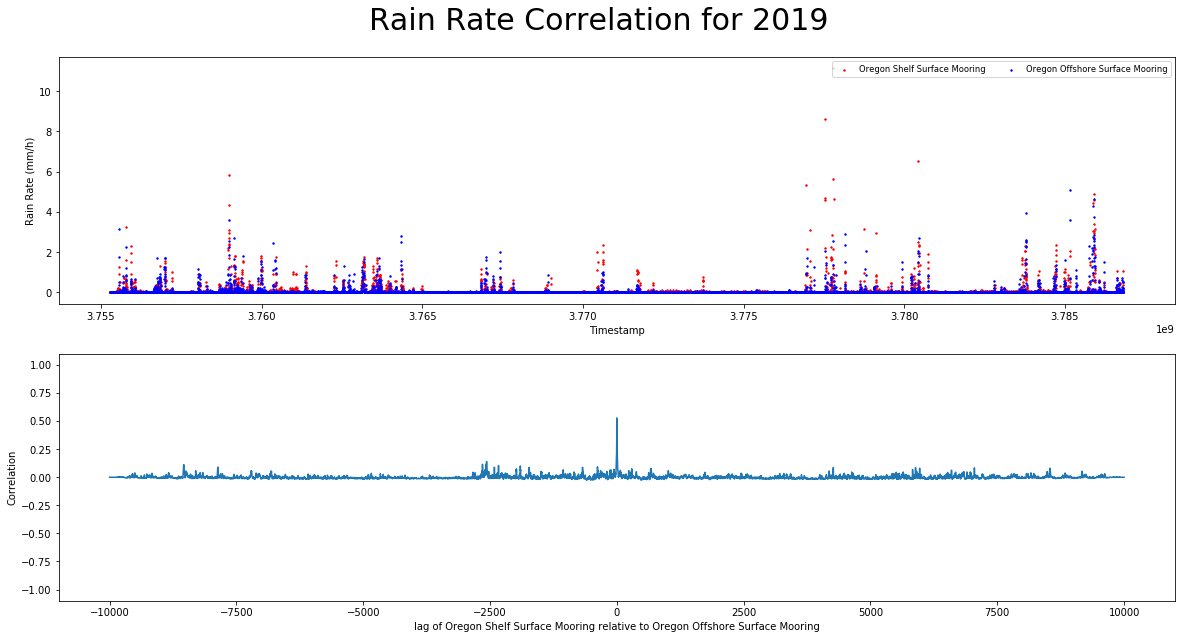

In [491]:
Correlation_Info = ['Rain Rate','mm/h','2019']
Correlate_THIS(Data1_OSSM.Time_Stamp, Data2_OOSM.Time_Stamp, Data1_OSSM.Rain_Rate, Data2_OOSM.Rain_Rate, Correlation_Info)



---


# **End of Project 2**

# Backup code for when code fails and I ugly cry

## Relevant comic

![alt text](https://66.media.tumblr.com/9c6e1d3782adcddc2aa311c24a01513f/tumblr_pdfj02heZ11scp87bo1_1280.jpg)

## Working examples

In [0]:
# #Cross correlation without interpolation across a unified time access
# x = Test1.Time_Stamp
# x2 = Test2.Time_Stamp
# npts = 10000

# y1 = Nan_Val_Masker(Test1.Time_Stamp,Test1.Wind_Speed)
# y2 = Nan_Val_Masker(Test2.Time_Stamp,Test2.Wind_Speed)

# ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
# ccor = ccov / (npts * y1.std() * y2.std())
# lags = np.linspace(-npts + 1, npts, len(ccor))

# fig, axs = plt.subplots(nrows=2)
# fig.subplots_adjust(hspace=0.4)
# ax = axs[0]
# ax.plot(x, y1, 'b', label='y1')
# ax.plot(x2, y2, 'r', label='y2')
# #ax.set_ylim(-10, 10)
# ax.legend(loc='upper right', fontsize='small', ncol=2)

# ax = axs[1]
# ax.plot(lags, ccor)
# ax.set_ylim(-1.1, 1.1)
# ax.set_ylabel('cross-correlation')
# ax.set_xlabel('lag of y1 relative to y2')

# maxlag = lags[np.argmax(ccor)]
# print("max correlation is at lag %d" % maxlag)

In [0]:
# print("standard deviations: ", Y2_data_needing_interpolation.std(), yfilled.std())

# fig, (ax0, ax1) = plt.subplots(2)
# fig.subplots_adjust(hspace=0.4)
# ax0.plot(X2_Time_Axis_Basis, Y2_data_needing_interpolation, 'bo', label='original') 
# ax0.plot(Universal_Time_Axis, yfilled, 'ro', label='interpolated')
# ax0.set_xlabel('time')
# ax0.set_ylabel('measurement')
# ax0.legend(loc='upper right', ncol=2, fontsize='small')
# ax0.set_ylim(-5, 5)

# lags, auto_x = autocorr(yfilled)
# ax1.plot(lags, auto_x, 'ro')

# for ax in (ax0, ax1):
#     ax.locator_params(axis='y', nbins=4)

# ax1.set_xlim(0, nt//3) # To see the smaller lags better.
# ax1.set_ylim(-1.1, 1.1)
# ax1.set_xlabel('lag')
# ax1.set_ylabel('autocorrelation')

## Code that has potential for greatness, but I am to weak to wield:

## Debugging code

In [0]:
# #View entire array for numpy

# np.set_printoptions(threshold=np.inf)

In [0]:
# #use this to view the entire data frame
# #you can change "None" to a number in order to re-enable limiting the output

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [0]:
# #This function tells me how many data points there are for each month in a 1 year span
# def CountData(DataBatch):
#   for m in range(1, 13):
#     count = 0
#     for i, DataPoint in enumerate(DataBatch):
#         if DataBatch[i].month == m:
#           count += 1

#     print('For Month: %d There are %s data points.' %(m,count))
#   print('There are %d points in total.' %(len(DataBatch)))


# #How to call function:
# CountData(Data1_OSSM.Time)